In [1]:
import paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
#import src.ckli.ckliest_testing as ckliest
import h5py
import GPy

In [2]:
amps = True
if amps:
    from cklemap.sdfs.darcy import DarcyExp
    from cklemap.sdfs.dasa import DASAExpKLAMPS
    import cklemap.ckli.mapest as mapest
else:
    from cklemap.sdfs.darcy_old import DarcyExp
    from cklemap.sdfs.dasa_old import DASAExpKL
    import cklemap.ckli.mapest_old as mapest

In [3]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [18]:
# Parameters
res_fac = 1
resolution = '1x'
ref_resolution = '16x'
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
Neumann_sd = 0
lsq_method = 'trf'
data_path = '../data/'
results_path = '../results/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
ref_geom_filename = data_path + f'geom/geom_{ref_resolution}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'RF2/conduct_log_RF2_{NYrefobs}_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
ref_yobs_filename = data_path + f'yobs/yobs_{NYobs}_{ref_resolution}.npy'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution}.npy'
ref = f"Yref=RF2_{NYrefobs}_{resolution}"

In [5]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)
prob = DarcyExp(TPFA(geom, bc), None)

Nc = geom.cells.num
Ninf = geom.faces.num_interior
print(f'Ninf = {Ninf}, Nc = {Nc}')

Ninf = 2766, Nc = 1475


In [6]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [7]:
# Observations
rs = npr.RandomState(seed)

# Read stochastic model from GPML output
with h5py.File(conduct_filename, 'r') as f:
    Yref = f.get('mu')[:].ravel() - Yfac
    CYpred = f.get('Kp')[:]
    xrefYobs = f.get('xYobs')[:]

uref = prob.randomize_bc('N', Neumann_sd).solve(Yref)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

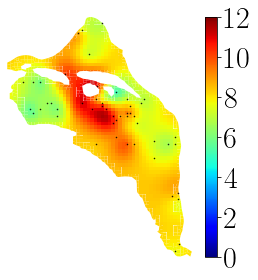

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
p = plot_patch(patches, Yref + Yfac, fig, ax, xrefYobs, 'Yref', 0, 12)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize='30')
cbar.locator = ticker.MaxNLocator(nbins=7)
cbar.update_ticks()
fig.tight_layout()
fig.savefig(f'../figures/Yref/Yref_{ref}.pdf', dpi=300)

In [9]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [10]:
if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
elif os.path.exists(ref_yobs_filename):
    print(f"iYobs set read from file {ref_yobs_filename} and randomly selected nearby cell")
    iYobs_4x = np.load(ref_yobs_filename)
    geom_4x = GeomMRST(ref_geom_filename)
    iYobs = np.array([geom.anyCellsWithin(geom_4x.nodes.coords.T[geom_4x.cells.nodes.T[iYobs_4x[t]]]) for t in range(num_trials)])
    np.save(yobs_filename, iYobs)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs set read from file ../data/yobs/yobs_100_1x.npy
iYobs.shape=(10, 100)
[[   4   14   31   34   52   53   54   82   89  122  141  142  148  152
   187  191  192  218  231  254  260  278  302  315  322  326  333  342
   347  361  362  364  376  408  420  427  431  434  438  446  458  465
   481  483  487  529  535  536  554  558  587  597  620  651  667  674
   737  758  761  838  847  853  857  863  884  897  900  930  942  961
  1001 1003 1030 1031 1054 1061 1069 1081 1095 1114 1122 1126 1131 1157
  1164 1175 1178 1187 1239 1270 1280 1285 1305 1338 1347 1352 1402 1438
  1444 1465]
 [  22   33   56   60   71   92  104  117  118  138  146  181  183  213
   216  227  246  248  276  302  306  311  329  333  336  352  378  388
   396  406  410  418  436  454  495  496  499  509  533  537  542  543
   545  547  548  600  611  615  641  643  648  668  673  678  681  692
   695  701  719  760  783  786  787  800  802  806  840  841  872  885
   906  918  933  954  961  965  968  998  999 

In [11]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{NYxi=}_gamma={gamma_map}_cklmap_h1reg_{amps=}_{ref}'
print(exp)

NY=100_Nu=323_NYlearn=100_NYxi=1000_gamma=1e-06_cklmap_h1reg_amps=True_Yref=RF2_50_1x


In [12]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))

Yxi = np.zeros((num_trials, NYxi))
Yest = np.zeros((num_trials, Nc))

In [13]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    print(f"{klearn.lengthscale.values[0]=}")
    print(f"{np.sqrt(klearn.variance.values[0])=}")

    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t,:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0008   4.097870e+01   1.007759e+01 
    00s06  0013   4.063168e+01   2.353286e-06 
    00s07  0015   4.063168e+01   5.279878e-08 
Runtime:     00s07
Optimization status: Converged

klearn.lengthscale.values[0]=0.09259230123264314
np.sqrt(klearn.variance.values[0])=1.3428863243636697
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0004   8.295370e+01   6.300231e+04 
    00s04  0010   5.596017e+01   3.583756e+01 
    00s07  0015   5.395934e+01   6.263121e-01 
    00s09  0020   5.394666e+01   3.512408e-09 
Runtime:     00s09
Optimization status: Converged

klearn.lengthscale.values[0]=0.08179049898928485
np.sqrt(klearn.variance.values[0])=1.3249775669441262
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   5.372710e+01   1.914091e+02 
    00s04  0010   5.151068e+01   6.15981

In [14]:
# PICKLE models
Ym = Ypred
CYm = CYpred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.15600737 0.1338206  0.12055036 0.1372624  0.15568691 0.17484767
 0.12667527 0.11767154 0.14414598 0.16902939]
GPR	Infinity error: [1.60853612 1.31367286 1.04654308 1.40692    1.50469436 1.59352909
 1.04176862 1.49170934 1.33723046 2.37278545]


In [15]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [1.72849048 1.69224309 1.66689393 1.71572199 1.68577273 1.66589389
 1.71939997 1.72217759 1.71541164 1.68439911] s


In [16]:
# MAP H1 estimate
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpKLAMPS(loss.val, loss.grad_u, loss.grad_Y, prob.partial_solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t], prob.u_sens_p, (Nuobs + NYobs + Ninf, NYxi), Nuobs)
    else:
        dasa = DASAExpKL(loss.val, loss.grad_u, loss.grad_Y, prob.solve, prob.residual_sens_u, prob.residual_sens_Y, Ym[t], PsiY[t])
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(NYxi), jac=dasa.grad, method=lsq_method, verbose=2)
    Yest[t] = Ym[t] + PsiY[t] @ sol.x
    MAP_status = sol.status
    timings[t, 4] = perf_counter() - ts
    nfevs[t, 1] = sol.nfev
    print(f'CKLEMAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

print(f"MAP: {timings[:, 4]} s")
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0212e+00                                    3.39e+00    
       1              2         7.0103e-01      2.32e+00       1.00e+00       4.66e-01    
       2              3         2.3016e-01      4.71e-01       2.00e+00       7.18e-02    
       3              4         2.2627e-02      2.08e-01       4.00e+00       2.42e-02    
       4              5         7.8706e-04      2.18e-02       8.00e+00       1.68e-02    
       5              6         1.2784e-04      6.59e-04       1.60e+01       1.20e-02    
       6              8         8.8832e-05      3.90e-05       8.00e+00       2.20e-03    
       7             10         8.4840e-05      3.99e-06       4.00e+00       5.27e-04    
       8             11         8.2857e-05      1.98e-06       8.00e+00       1.79e-03    
       9             12         8.0481e-05      2.38e-06       8.00e+00       1.81e-03    

In [19]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest)